In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import StandardScaler
from preprocessing.sliding_window import create_windowed_dataset
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

### Data loading

In [3]:
data_path = '../data/processed/usc-had.csv'
df = pd.read_csv(data_path)

In [4]:
df.head()

,subject,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,activity
0,11,0.788496,0.429586,0.158079,-9.520525,1.719961,-0.391400,2
1,11,0.795364,0.425966,0.176379,-8.312029,-0.693527,0.414264,2
2,11,0.819400,0.454920,0.205661,-5.492205,-3.495776,1.622760,2
3,11,0.815967,0.454920,0.212981,0.147443,-5.509936,0.817096,2
4,11,0.840003,0.454920,0.209321,3.772932,-9.135425,-0.794232,2


In [5]:
FEATURES = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
LABEL = 'activity'

In [6]:
df = df.fillna(0)
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [7]:
hyperparameters = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)

metadata = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)['uschad_preprocess']

In [8]:
train_subject = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
val_subject = [12]
test_subject = [13, 14]

In [9]:
train_df = df.loc[df['subject'].isin(train_subject)]
val_df = df.loc[df['subject'].isin(val_subject)]
test_df = df.loc[df['subject'].isin(test_subject)]

SLIDING_WINDOW_LENGTH = metadata['sliding_win_len']
SLIDING_WINDOW_STEP = metadata['sliding_win_stride']
N_WINDOW, N_TIMESTEP = metadata['n_window'], metadata['n_timestep']

# FEATURES = metadata['feature_list']

X_train, y_train = create_windowed_dataset(
    train_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_val, y_val = create_windowed_dataset(
    val_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test = create_windowed_dataset(
    test_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_train = X_train.reshape(
    (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_val = X_val.reshape(
    (X_val.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape(
    (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
print(X_train.shape)
print(y_train.shape)

(20206, 10, 20, 6)
(20206, 13)


In [11]:
y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=metadata['n_window'], axis=1)
y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=metadata['n_window'], axis=1)
y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=metadata['n_window'], axis=1)

In [12]:
y_train_mid.shape

(20206, 10, 13)

In [88]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
DATASET_NAME = 'uschad'
hparams_all = hyperparameters['HSA_model']
hparams = hparams_all[DATASET_NAME]

hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
hparams['n_outputs_window']=  y_train.shape[1]

## Training

In [89]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

8 Physical GPUs, 8 Logical GPUs


In [90]:
tf.keras.backend.clear_session()
device_list = ['/gpu:'+str(i) for i in range(5, 8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hparams).get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 3


In [91]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 20, 6)]  0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 128),  989952      input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_1 (Modal (None, None, 128)    675968      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 128), (None, 329600      modality_encoder_block_1[0][0]   
____________________________________________________________________________________________

In [92]:
checkpoint_filepath = "usc_checkpoints/cp-{epoch:04d}.ckpt"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               verbose=1)

In [93]:
history = model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 128, epochs=15, validation_data=(X_val, [y_val_mid, y_val]), use_multiprocessing=True, callbacks=[model_checkpoint_callback] )

Epoch 1/15
INFO:tensorflow:batch_all_reduce: 100 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 100 all-reduces with algorithm = nccl, num_packs = 1
53/53 [==============================] - ETA: 0s - session_pred_accuracy: 0.6333 - window_pred_accuracy: 0.6515 - loss: 1.8638 - session_pred_loss: 0.9571 - window_pred_loss: 0.9067
Epoch 00001: saving model to usc_checkpoints/cp-0001.ckpt
53/53 [==============================] - 15s 287ms/step - session_pred_accuracy: 0.6333 - window_pred_accuracy: 0.6515 - loss: 1.8638 - session_pred_loss: 0.9571 - window_pred_loss: 0.9067 - val_session_pred_accuracy: 0.8847 - val_window_pred_accuracy: 0.8679 - val_loss: 0.7299 - val_session_pred_loss: 0.3612 - val_window_pred_loss: 0.3687
Epoch 2/15
53/53 [==============================] - ETA: 0s - session_pred_accuracy: 0.8049 - window_pred_accuracy: 0.8040 - loss: 0.9944 - session_pred_loss: 0.4970 - window_pred_loss: 0.4975
Epoch 00002: saving model to usc_checkpo

In [106]:
model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 128, epochs=15, validation_data=(X_val, [y_val_mid, y_val]), use_multiprocessing=True, callbacks=[model_checkpoint_callback] )

Epoch 1/15
53/53 [==============================] - ETA: 0s - session_pred_accuracy: 0.8840 - window_pred_accuracy: 0.8840 - loss: 0.5314 - session_pred_loss: 0.2679 - window_pred_loss: 0.2635
Epoch 00001: saving model to usc_checkpoints/cp-0001.ckpt
53/53 [==============================] - 11s 201ms/step - session_pred_accuracy: 0.8840 - window_pred_accuracy: 0.8840 - loss: 0.5314 - session_pred_loss: 0.2679 - window_pred_loss: 0.2635 - val_session_pred_accuracy: 0.8987 - val_window_pred_accuracy: 0.8926 - val_loss: 0.5491 - val_session_pred_loss: 0.2831 - val_window_pred_loss: 0.2660
Epoch 2/15
53/53 [==============================] - ETA: 0s - session_pred_accuracy: 0.8924 - window_pred_accuracy: 0.8939 - loss: 0.4772 - session_pred_loss: 0.2397 - window_pred_loss: 0.2375
Epoch 00002: saving model to usc_checkpoints/cp-0002.ckpt
53/53 [==============================] - 10s 197ms/step - session_pred_accuracy: 0.8924 - window_pred_accuracy: 0.8939 - loss: 0.4772 - session_pred_loss: 0

In [115]:
pred_mid, pred_sess = model.predict(X_test, batch_size=len(device_list) * 128)

In [116]:
activity_map = { 1:'Walking Forward', 2:'Walking Left',  3:'Walking Right',
                4:'Walking Upstairs', 5:'Walking Downstairs', 6:'Running Forward',
                7:'Jumping Up', 8:'Sitting', 9:'Standing', 10: 'Sleeping',
                11:'Elevator Up', 12:'Elevator Down'}
activity_list = list(activity_map.values())

In [117]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), labels=list(activity_map.keys()), target_names=activity_list))

                    precision    recall  f1-score   support

   Walking Forward       0.92      0.58      0.71       764
      Walking Left       0.57      0.75      0.65       481
     Walking Right       0.82      0.57      0.67       404
  Walking Upstairs       0.37      0.80      0.51       187
Walking Downstairs       0.70      0.61      0.65       180
   Running Forward       0.98      0.91      0.94       401
        Jumping Up       0.83      0.47      0.60       179
           Sitting       0.56      0.77      0.64       490
          Standing       0.18      0.09      0.12       340
          Sleeping       1.00      0.85      0.92       740
       Elevator Up       0.00      0.00      0.00       208
     Elevator Down       0.14      0.51      0.22       178

          accuracy                           0.63      4552
         macro avg       0.59      0.58      0.55      4552
      weighted avg       0.69      0.63      0.64      4552



<AxesSubplot:>

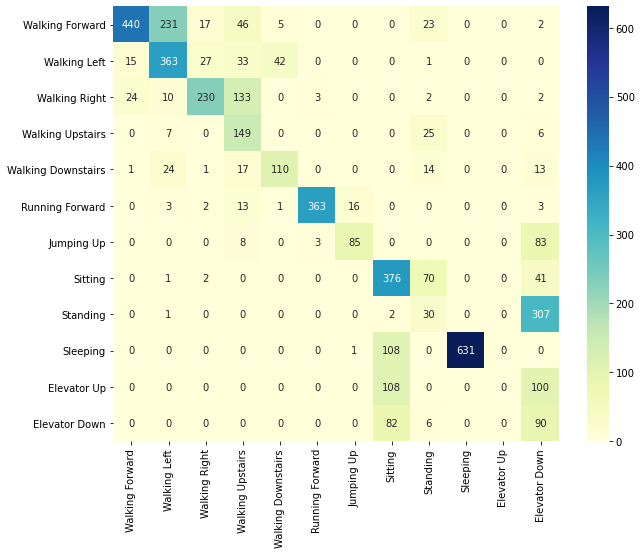

In [118]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [119]:
y_test_mid.shape

(4552, 10, 13)

In [120]:
pred_mid.shape

(4552, 10, 13)

In [121]:
print(classification_report(np.argmax(y_test_mid.reshape(-1, 13), axis=1), np.argmax(pred_mid.reshape(-1, 13), axis=1), labels=list(activity_map.keys()), target_names=activity_list))

                    precision    recall  f1-score   support

   Walking Forward       0.91      0.57      0.70      7640
      Walking Left       0.57      0.76      0.65      4810
     Walking Right       0.82      0.58      0.68      4040
  Walking Upstairs       0.39      0.79      0.52      1870
Walking Downstairs       0.72      0.62      0.67      1800
   Running Forward       0.97      0.90      0.94      4010
        Jumping Up       0.82      0.50      0.62      1790
           Sitting       0.52      0.74      0.61      4900
          Standing       0.10      0.05      0.07      3400
          Sleeping       1.00      0.82      0.90      7400
       Elevator Up       0.03      0.01      0.02      2080
     Elevator Down       0.15      0.50      0.23      1780

          accuracy                           0.62     45520
         macro avg       0.58      0.57      0.55     45520
      weighted avg       0.68      0.62      0.63     45520



<AxesSubplot:>

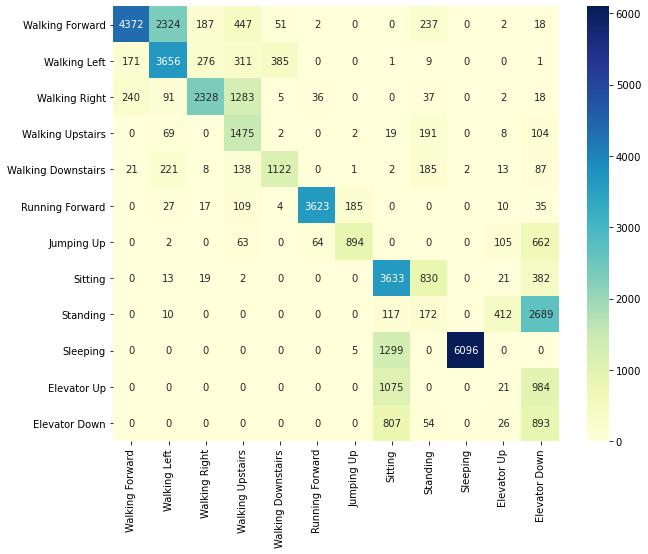

In [122]:
confm = confusion_matrix(np.argmax(y_test_mid.reshape(-1, 13), axis=1), np.argmax(pred_mid.reshape(-1, 13), axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")